In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from scipy.interpolate import interp1d
from scipy.signal import resample, find_peaks, peak_prominences
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import LeaveOneOut

from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_ibis,
    get_hr
)

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

### Process data for all 7 subjects

In [2]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

### Implement custom subclass of SKLearn's RF Regressor

In [11]:
class MoodTriggersRegressor(RandomForestRegressor):
    
    def __init__(self, data, label_col = 'bvp', subject_col = 'subject', random_state = 0, kfold = False,
                # hyperparameters
                split_size = 1280, test_size = 0.3,
                *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # instance variables
        self.data = data
        self.label_col = label_col
        self.subject_col = subject_col
        self.split_size = split_size
        self.test_size = test_size
        self.random_state = random_state
        self.kfold = kfold
        self.tree_weights_ = None

        if self.kfold:
            
            self.kfold_sets = {}
            subjects = self.data[self.subject_col].unique()
            for subject in subjects:
                
                data_in_use = self.data[self.data[self.subject_col] != subject]

                train_splits = self.split_data(to_exclude = [subject])
                test_splits = self.split_data(to_exclude = subjects[subjects != subject])

                train_indices = [idx for split in train_splits for idx in split]
                train_data = data_in_use.iloc[train_indices]
                train_X = train_data.drop(columns = [self.label_col, self.subject_col]).to_numpy()
                train_y = train_data[self.label_col].to_numpy()

                test_indices = [idx for split in test_splits for idx in split]
                test_data = data_in_use.iloc[test_indices]
                test_X = test_data.drop(columns = [self.label_col, self.subject_col]).to_numpy()
                test_y = test_data[self.label_col].to_numpy()

                self.kfold_sets[subject] = (train_X, train_y, test_X, test_y, train_splits, test_splits)

        # create consecutive splits in the data and then randomly sample from the splits
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        
        # split up the training and testing splits
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        # create the training dataset from the training splits
        train_indices = [idx for split in self.train_splits for idx in split]
        self.train_data = self.data.iloc[train_indices]
        self.train_X = self.train_data.drop(columns = [self.label_col, self.subject_col]).to_numpy()
        self.train_y = self.train_data[self.label_col].to_numpy()

        # create the testing dataset from the testing splits
        test_indices = [idx for split in self.test_splits for idx in split]
        self.test_data = self.data.iloc[test_indices]
        self.test_X = self.test_data.drop(columns=[self.label_col, self.subject_col]).to_numpy()
        self.test_y = self.test_data[self.label_col].to_numpy()
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.data if to_exclude is None else self.data[~self.data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        super().fit(self.train_X, self.train_y)

    def predict(self, X):
        return super().predict(X)
    
    def predict_with_weights(self, X):

        if self.tree_weights_ is None:
            self.use_tree_weights()
                
        preds = np.array([tree.predict(X) for tree in self.estimators_])
        wpreds = np.average(preds, axis = 0, weights = self.tree_weights_)
        return wpreds

    def eval(self, with_weights = True, with_processing = True):

        pred_method = self.predict_with_weights if with_weights else self.predict
        
        pred = pred_method(self.test_X)
        targs = self.test_y
        if with_processing:
            targs, pred = self._process(targs, pred)
       
        mse = mean_squared_error(targs, pred)

        # get the model's performance at calculating HR
        groups_x, groups_y = self._get_groupings(self.test_splits)
        hr_errs = []
        for x, y in zip(groups_x, groups_y):
            
            pred = pred_method(x)
            targs = y

            if with_processing:
                targs, pred = self._process(targs, pred)

            err = self.get_peaks_err(targs, pred)
            hr_errs.append(err)

        return mse, np.mean(hr_errs), np.mean([pow(e, 0.5) for e in hr_errs])
    
    def eval_kfold(self, with_weights = True, with_processing = True):

        errs = {}
        mses = []
        hr_errs = []
        hr_err_sqrts = []
        for subject, (train_X, train_y, test_X, test_y, train_splits, test_splits) in self.kfold_sets.items():

            self.train_X = train_X
            self.train_y = train_y
            self.test_X = test_X
            self.test_y = test_y
            self.train_splits = train_splits
            self.test_splits = test_splits

            self.fit()
            mse, hr_err, hr_err_sqrt = self.eval(with_weights = with_weights, with_processing = with_processing)
            errs[subject] = (len(test_splits), mse, hr_err, hr_err_sqrt)
            mses.append(mse)
            hr_errs.append(hr_err)
            hr_err_sqrts.append(hr_err_sqrt)

        return np.mean(mses), np.mean(hr_errs), np.mean(hr_err_sqrts), errs

    def feature_importances(self):
        importances = self.feature_importances_
        feature_names = self.data.drop(columns = [self.label_col, self.subject_col]).columns
        result = pd.DataFrame({'feature': feature_names, 'importance': importances})
        result = result.sort_values(by='importance', ascending=False)
        return result

    def use_tree_weights(self, with_processing = True):
        
        groups_x, groups_y = self._get_groupings(self.train_splits)
        
        # loop through each tree and the group of features for that tree
        tree_errors = []
        error_sum = 0

        for tree in self.estimators_:
            
            # iterate through each pair of data and target variables
            errs = []
            for x, y in zip(groups_x, groups_y):
                
                pred = tree.predict(x)
                targs = y
                if with_processing:
                    targs, pred = self._process(targs, pred)        
                
                err = self.get_peaks_err(targs, pred)
                errs.append(err)
            
            err_mean = np.mean(errs)
            tree_errors.append(err_mean)
            error_sum += err_mean
        
        tree_weights = np.array(tree_errors) / error_sum
        tree_weights = 1 - tree_weights
        tree_weights /= np.sum(tree_weights)
        self.tree_weights_ = tree_weights

    def get_peaks_err(self, targs, pred):
        
        pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, -1, prominence = 0.1, with_min_dist = True, with_valleys = False)
        true_peaks, _ = get_peaks_v2(targs, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

        pred_ibis = get_ibis(pred_peaks, 64)
        true_ibis = get_ibis(true_peaks, 64)
        
        pred_hr = get_hr(pred_ibis)
        true_hr = get_hr(true_ibis)

        return pow(true_hr - pred_hr, 2)

    def _get_groupings(self, splits):
            
        groups_x = []
        groups_y = []
        for split in splits:
            
            split_data = self.data.iloc[split]
            split_X = split_data.drop(columns=[self.label_col, self.subject_col])
            split_y = split_data[self.label_col]
            
            groups_x.append(split_X.to_numpy())
            groups_y.append(split_y.to_numpy())
        
        return groups_x, groups_y

    @staticmethod
    def _process(targs, signal, smoothing_window = 10, use_bandpass = False):
        
        orig_len = len(signal)
        signal = n_moving_avg(signal, smoothing_window)
        signal = resample(signal, orig_len)
        if use_bandpass:
            signal = bandpass(signal, 64, [0.67, 3.0], 4)
        signal = min_max_scale(signal)
        
        targs = n_moving_avg(targs, 20)
        targs = resample(targs, orig_len)
        targs = min_max_scale(targs)
        
        return targs, signal

### Train the model on all subjects except 1

In [4]:
test_subject = 5

data_arr = []
for i in range(len(truths)):
    
    if i == (test_subject - 1):
        continue
    
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)
display(data.head())
chrom = data[data.subject == 1].chrom

rf = MoodTriggersRegressor(data, n_estimators = 100)
rf.fit()
mse, hr_errs, hr_errs_absolute = rf.eval()

print(f'MSE: {mse}')
print(f'HR error: {hr_errs}')
print(f'HR Error absolute: {hr_errs_absolute}')
print(f'Feature importances:')
display(rf.feature_importances())


,chrom,r,g,b,r_diff,g_diff,b_diff,bvp,subject
1000,0.588770,0.498481,0.495549,0.495504,0.000026,-0.000607,-0.000478,0.039463,1
1001,0.620292,0.498622,0.495054,0.495039,0.000141,-0.000496,-0.000465,0.037491,1
1002,0.647936,0.498859,0.494684,0.494575,0.000237,-0.000370,-0.000464,0.034246,1
1003,0.669970,0.499150,0.494427,0.494076,0.000290,-0.000257,-0.000499,0.029799,1
1004,0.684822,0.499496,0.494310,0.493559,0.000346,-0.000117,-0.000516,0.024385,1


MSE: 0.005455721488116491
HR error: 753.3235798267472
HR Error absolute: 23.000000949943107
Feature importances:


,feature,importance
1,r,0.176197
3,b,0.159311
0,chrom,0.154703
2,g,0.149732
6,b_diff,0.138377
4,r_diff,0.115389
5,g_diff,0.106290


In [12]:
data_arr = []
for i in range(len(truths)):
    
    if i == (test_subject - 1):
        continue
    
    truth = truths[i]
    data = truth.prepare_data_for_ml()
    data = data.iloc[1000: 15000, :]
    
    data['subject'] = i + 1
    data_arr.append(data)

data = pd.concat(data_arr)

rf = MoodTriggersRegressor(data, n_estimators = 100, kfold = True)
mean_mse, mean_hr_err, mean_sqrt_hr_err, summary = rf.eval_kfold()

summary

{1: (10, 0.002580460750699359, 706.5147218931941, 23.80126916386996),
 2: (10, 0.0027145788224070505, 22.1814967710981, 2.63406197437621),
 3: (10, 0.0021476131117458496, 18.776106966325166, 2.2559871642655076),
 4: (2, 0.002646914265081739, 44.68387416384755, 4.786799222905355),
 6: (10, 0.0009540448294540255, 4.856679301365668, 1.325183990996355),
 7: (10, 0.004726826980702714, 10.139574488458177, 1.6484830942254667)}

In [13]:
print(mean_mse, mean_hr_err, mean_sqrt_hr_err)

0.002628406460015123 134.5254089307148 6.075297435106477


In [5]:
rec = {
    'w/o wave': (0.014966182095387174, 696.1679901518303),
    'w/ wave': (0.06851164298744652, 335.74974096112766),
    'w/ bandpass and wave w/ bandpass first': (0.02288918317382276, 883.0830443688016),
    'w/ bandpass and wave w/ wave first': (0.013029571137835922, 619.7491567908635),
    'w/ min max scaling and everything else': (0.006137550724635535, 527.8052162904935),
    'w/ prev but also with chrom': (0.0053205282220937684, 532.8225611310841)
}

True HR: 109.80935875216637; Pred HR: 108.3076923076923


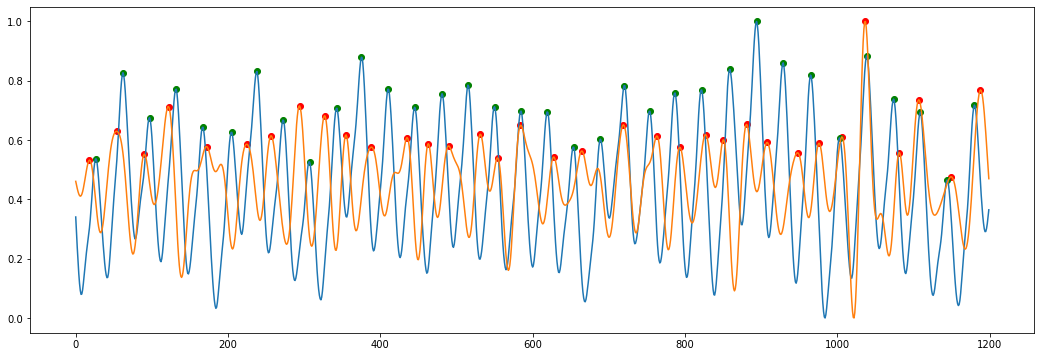

In [14]:
beg = 1200
end = 2400

# get data for subject not in test set and get x and y for prediction
data = truths[test_subject-1].prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = rf.predict(x)[beg: end]
targ, pred = rf._process(targ, pred)
# pred = apply_wavelet(pred, 'db2', 2)
pred = bandpass(pred, 64, [0.67, 3.0], 4)
pred = min_max_scale(pred)

pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, 0.1, prominence = 0.05, with_min_dist = True, with_valleys = False)
true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = get_ibis(pred_peaks, 64)
true_ibis = get_ibis(true_peaks, 64)
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')


In [7]:
import numpy as np
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def normalized_mutual_information(x, y, n_bins=10):
    # Discretize the continuous variables using a fixed number of bins
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    
    x_discrete = discretizer.fit_transform(x.reshape(-1, 1)).ravel().astype(int)
    y_discrete = discretizer.fit_transform(y.reshape(-1, 1)).ravel().astype(int)

    # Compute mutual information between the discretized variables
    mi = mutual_info_score(x_discrete, y_discrete)

    # Normalize the mutual information by the entropy of the two variables
    entropy_x = -np.sum(np.bincount(x_discrete) / len(x_discrete) * np.log2(np.bincount(x_discrete) / len(x_discrete) + np.finfo(float).eps))
    entropy_y = -np.sum(np.bincount(y_discrete) / len(y_discrete) * np.log2(np.bincount(y_discrete) / len(y_discrete) + np.finfo(float).eps))

    nmi = mi / np.sqrt(entropy_x * entropy_y)
    return nmi

# Test the function with two continuous variables
x = np.random.rand(100)
y = 2 * x + np.random.normal(0, 0.1, 100)

nmi = normalized_mutual_information(x, y)
print("Normalized mutual information:", nmi)


Normalized mutual information: 0.4271596705795212


NMI: 0.26725399569543673
1200 1200


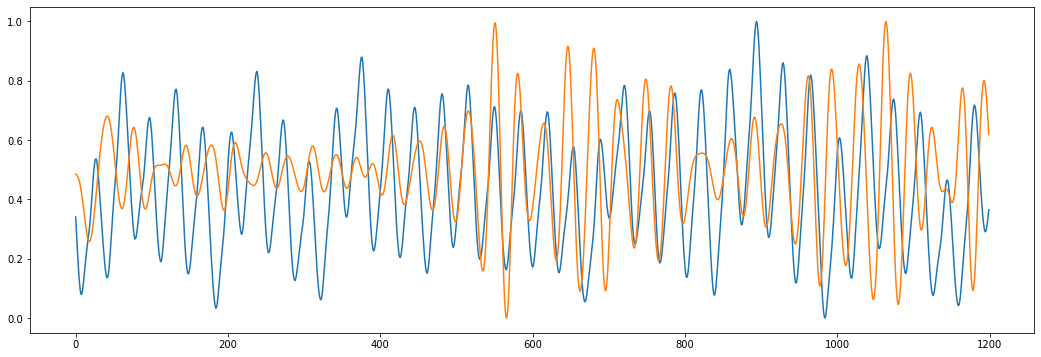

In [8]:
from chrominance import chrominance, CHROM_SETTINGS

sig = data[['r', 'g', 'b']].to_numpy()
chrom = chrominance(sig, CHROM_SETTINGS, None, False)
chrom = chrom[beg: end]
# plt.plot(chrom)
chrom = apply_wavelet(chrom, 'db2', 2)
# plt.plot(chrom)
chrom = bandpass(chrom, 64, [0.67, 3.0], 4)
chrom = min_max_scale(chrom)
plt.plot(targ)
plt.plot(chrom)
print(f'NMI: {normalized_mutual_information(targ, chrom, n_bins = 100)}')
print(len(chrom), len(pred))

In [9]:
# beg = 1200
# end = 2400

# # get data for subject not in test set and get x and y for prediction
# data = truths[test_subject-1].prepare_data_for_ml()
# x = data.drop(columns = ['bvp']).to_numpy()

# y = data['bvp'].to_numpy()
# targ = [truths[test_subject-1].bvp[0]]
# for i in range(len(y)):
#     targ.append(targ[i] + y[i])
# targ = targ[beg: end]

# pred = rf.predict(x)[beg: end]
# pred_official = [truths[test_subject-1].bvp[0]]
# for i in range(len(pred)):
#     pred_official.append(pred_official[i] + pred[i])
# targ, pred = rf._process(targ, pred_official)
# pred = detrend_w_poly(pred)
# pred = min_max_scale(pred)

# pred_peaks, _ = get_peaks_v2(pred, 64, 3.0, 0.1, prominence = 0.15, with_min_dist = True, with_valleys = False)
# true_peaks, _ = get_peaks_v2(targ, 64, 3.0, -1, prominence = 0, with_min_dist = True, with_valleys = False)

# plt.plot(targ)
# plt.plot(pred)
# plt.scatter(pred_peaks, pred[pred_peaks], c='r')
# plt.scatter(true_peaks, targ[true_peaks], c='g')

# pred_ibis = get_ibis(pred_peaks, 64)
# true_ibis = get_ibis(true_peaks, 64)
# pred_hr = get_hr(pred_ibis)
# true_hr = get_hr(true_ibis)
# print(f'True HR: {true_hr}; Pred HR: {pred_hr}')

In [18]:
type(data.indices)

AttributeError: 'DataFrame' object has no attribute 'indices'